# Gaussian Process

In this notebook I show how we can use Gaussian Process (GP) for regression. In particular, I will show how we can model the supernova light curves (brightness versus time) using the hierarchical Gaussian processes (also known as Bayesian smoothing splines) to interpolate the magnitudes at different epochs. This technique has the advantage over other methods of allowing the inclusion of uncertainty information, thus producing less-biased interpolated values. Additionally, this method is very powerful for SN light curves having incomplete or noisy photometric data. Finally, I also shown an example on Gaussian Process classification on the IRIS data.

## 1.) Gaussian process regression: George package

https://george.readthedocs.io/en/latest/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams['legend.numpoints']=1
plt.rcParams['xtick.major.size'] = 11
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 11
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.visible']=True #See minor tick
plt.rcParams['text.usetex']=True #use Latex
plt.rcParams['axes.linewidth']=2 #width axes
plt.rcParams['axes.labelsize']=25 #
plt.rcParams['ytick.labelsize']=22 #fontsize of tick labels
plt.rcParams['xtick.labelsize']=22 #fontsize of tick labels
plt.rcParams['ytick.direction']='inout' ## direction: in, out, or inout
plt.rcParams['xtick.direction']='inout' ## direction: in, out, or inout

plt.rcParams['xtick.major.top']=True #draw x axis top major ticks
plt.rcParams['xtick.major.bottom']=True #draw x axis bottom major ticks
plt.rcParams['xtick.minor.top']=True ## draw x axis top minor ticks
plt.rcParams['xtick.minor.bottom']=True #draw x axis bottom minor ticks

plt.rcParams['ytick.major.left']=True #draw y axis left major ticks
plt.rcParams['ytick.major.right']=True #draw y axis right major ticks
plt.rcParams['ytick.minor.left']=True ## draw y axis left minor ticks
plt.rcParams['ytick.minor.right']=True #draw y axis right minor ticks
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize']=22
plt.rcParams['figure.titlesize']=22

plt.rcParams['text.latex.preamble']=[r'\boldmath']

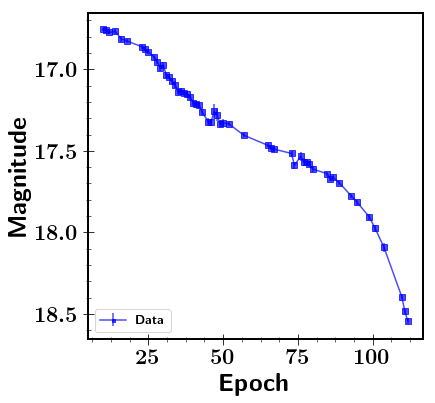

In [3]:
#Load the light curve
data=np.loadtxt('SN2005J.dat').transpose()
#we look at the V-band
ep=data[0]-2453379.8 #Texplosion
mag=data[11]
err=data[12]
fig,ax1 = plt.subplots(figsize=(6,6), facecolor='w', edgecolor='k')
ax1.errorbar(ep,mag,yerr=err,marker='s', color='b',alpha=0.7,label=r'\textbf{Data}')
ax1.set_xlabel(r'\textbf{Epoch}')
ax1.set_ylabel(r'\textbf{Magnitude}')
ax1.invert_yaxis()
ax1.legend(loc=3,markerscale=0.5,prop={'size':13},ncol=1)

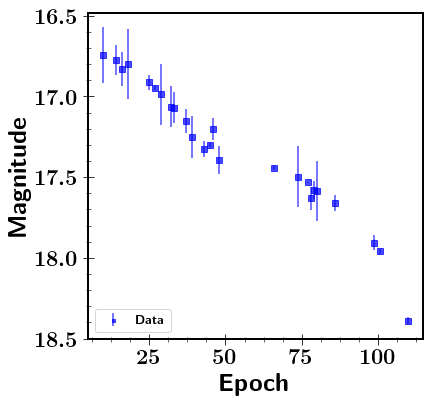

In [4]:
#I will increase the errorbar and put more scatter in the light curve.
mag=data[11]+ data[12] *2.0* np.random.randn(len(ep))
np.random.seed(1)
err=data[12]+np.random.randn(len(ep))/10

#Take less data
N_rand=25
ep_rand=np.random.choice(ep, N_rand, replace=False)
ind_rand=[np.where(np.array(ep)==i)[0][0] for i in ep_rand]
ep,mag,err=ep[ind_rand],mag[ind_rand],err[ind_rand]
fig,ax1 = plt.subplots(figsize=(6,6), facecolor='w', edgecolor='k')
ax1.errorbar(ep,mag,yerr=err,marker='s', color='b',alpha=0.7,linestyle='None',label=r'\textbf{Data}')
ax1.set_xlabel(r'\textbf{Epoch}')
ax1.set_ylabel(r'\textbf{Magnitude}')
ax1.invert_yaxis()
ax1.legend(loc=3,markerscale=0.5,prop={'size':13},ncol=1)

Optimization terminated successfully.


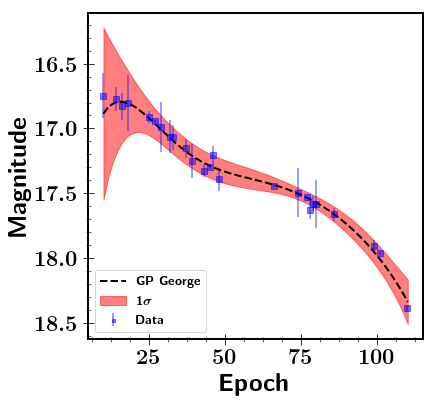

In [5]:
import george
#Kernel george
kernel = george.kernels.ExpSquaredKernel(0.5)
model = george.GP(kernel)
## Predicted epochs
nepochs =  200+10
epochs = np.linspace(10,110,nepochs)

#In nice to work in flux, mag=-2.5log10(f)+cte
ep,fl,efl=ep,10**(-0.4*mag),10**(-0.4*(mag))*(err*np.log(10)*1.0/(2.5))
#Normalization
fmax = np.max(fl)
ep,fl,efl = np.array(ep),np.array(fl)/fmax,np.array(efl)/fmax
# George Kerne
kernelGP = np.var(fl) * kernel
modelGP = george.GP(kernelGP)
modelGP.compute(ep, efl)

trefepoch,terrfac=-10,5
lgep = np.arcsinh(ep-trefepoch)
lgepochs = np.arcsinh(epochs-trefepoch)#arcsinh
## -- Pre-compute the factorization of the matrix.
modelGP.compute(lgep, efl*terrfac)
## -- Compute the log likelihood.
modelGP.lnlikelihood(fl)
## -- optimize (only george 0.2.1)
modelGP.optimize(lgep,fl,efl*terrfac)
## -- Prediction
tmu, tvar = modelGP.predict(fl, lgepochs)
tstd = np.sqrt(np.diag(tvar))
mu,std = np.reshape(tmu,nepochs),np.reshape(tstd,nepochs)

#plot
mag_pred,err_mag_pred=np.array(-2.5*np.log10(mu*fmax)),std*2*2.5/(mu*np.log(10))

fig,ax1 = plt.subplots(figsize=(6,6), facecolor='w', edgecolor='k')
ax1.errorbar(ep,mag,yerr=err,marker='s', color='b',alpha=0.5,linestyle='None',label=r'\textbf{Data}')
ax1.fill_between(epochs,mag_pred-err_mag_pred,mag_pred+err_mag_pred,alpha=0.5,color='r',label=r'\textbf{1$\sigma$}')
ax1.plot(epochs,mag_pred,'k--',lw=2,label=r'\textbf{GP George}')
ax1.set_xlabel(r'\textbf{Epoch}')
ax1.set_ylabel(r'\textbf{Magnitude}')
ax1.invert_yaxis()
ax1.legend(loc=3,markerscale=0.5,prop={'size':13},ncol=1)

## 2.) Gaussian process regression: Sklearn

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process.kernels import Matern

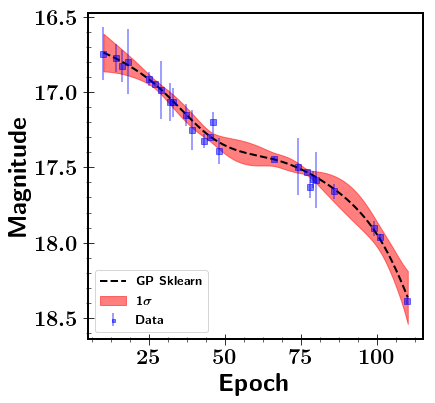

In [7]:
x = np.atleast_2d(epochs).T
kernel = Matern(length_scale=15000, length_scale_bounds=(1e-05, 100000.0), nu=1.5)
X = np.atleast_2d(ep).T

gp = GaussianProcessRegressor(kernel=kernel, alpha= (efl / fl) ** 2, n_restarts_optimizer=500)
gp.fit(X, fl)
y_pred, sigma = gp.predict(x, return_std=True)
mag_sklearn,err_mag_sklearn=np.array(-2.5*np.log10(y_pred*fmax)),sigma*2*2.5/(y_pred*np.log(10))

fig,ax1 = plt.subplots(figsize=(6,6), facecolor='w', edgecolor='k')
ax1.errorbar(ep,mag,yerr=err,marker='s', color='b',alpha=0.5,linestyle='None',label=r'\textbf{Data}')
ax1.fill_between(epochs,mag_sklearn-err_mag_sklearn,mag_sklearn+err_mag_sklearn,alpha=0.5,color='r',label=r'\textbf{1$\sigma$}')
ax1.plot(epochs,mag_sklearn,'k--',lw=2,label=r'\textbf{GP Sklearn}')
ax1.set_xlabel(r'\textbf{Epoch}')
ax1.set_ylabel(r'\textbf{Magnitude}')
ax1.invert_yaxis()
ax1.legend(loc=3,markerscale=0.5,prop={'size':13},ncol=1)

## 3.) Sklearn vs George

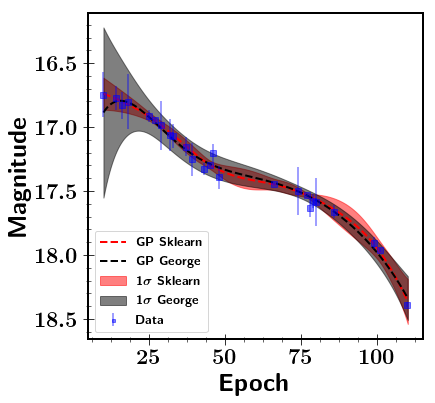

In [8]:
fig,ax1 = plt.subplots(figsize=(6,6), facecolor='w', edgecolor='k')
ax1.errorbar(ep,mag,yerr=err,marker='s', color='b',alpha=0.5,linestyle='None',label=r'\textbf{Data}')
ax1.fill_between(epochs,mag_sklearn-err_mag_sklearn,mag_sklearn+err_mag_sklearn,alpha=0.5,color='r',label=r'\textbf{1$\sigma$ Sklearn}')
ax1.plot(epochs,mag_sklearn,'r--',lw=2,label=r'\textbf{GP Sklearn}',zorder=1)

ax1.fill_between(epochs,mag_pred-err_mag_pred,mag_pred+err_mag_pred,alpha=0.5,color='k',label=r'\textbf{1$\sigma$ George}')
ax1.plot(epochs,mag_pred,'k--',lw=2,label=r'\textbf{GP George}',zorder=1)

ax1.set_xlabel(r'\textbf{Epoch}')
ax1.set_ylabel(r'\textbf{Magnitude}')
ax1.invert_yaxis()
ax1.legend(loc=3,markerscale=0.5,prop={'size':13},ncol=1)

## 4.) Gaussian process classification: GaussianProcessClassifier


In [9]:
# Import the data
from sklearn import datasets
import pandas as pd
iris = datasets.load_iris()
Sepal_length=iris['data'][:,0]
Sepal_width=iris['data'][:,1]
class_iris=iris['target']

Text(0,0.5,'\\textbf{Sepal width}')

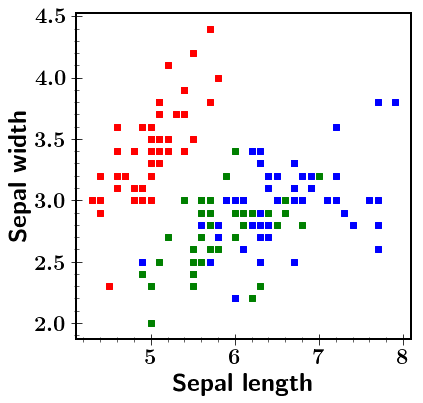

In [10]:
fig,ax1 = plt.subplots(figsize=(6,6), facecolor='w', edgecolor='k')
ax1.scatter(Sepal_length,Sepal_width,marker='s',  c=np.array(["r", "g", "b"])[class_iris],alpha=1)
ax1.set_xlabel(r'\textbf{Sepal length}')
ax1.set_ylabel(r'\textbf{Sepal width}')


Text(0,0.5,'\\textbf{Sepal width}')

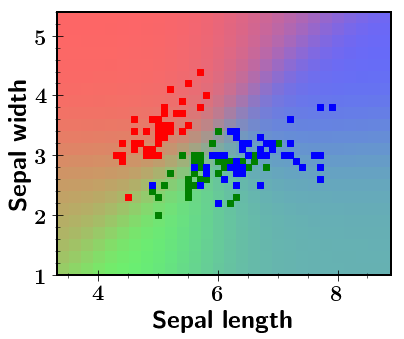

In [11]:
#import libraries
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

#Define Kernel
kernel = kernel = DotProduct() + WhiteKernel()#1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(np.vstack((Sepal_length,Sepal_width)).T, class_iris)

# create a mesh to plot the predicted probabilities
x_min, x_max =Sepal_length.min() - 1, Sepal_length.max() + 1
y_min, y_max = Sepal_width.min() - 1, Sepal_width.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),np.arange(y_min, y_max, 0.2))

#Predicted probabilities
Z = gpc_rbf_anisotropic.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
#Plot
fig,ax1 = plt.subplots(figsize=(6,6), facecolor='w', edgecolor='k')
ax1.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower",alpha=0.6)

ax1.scatter(Sepal_length,Sepal_width,marker='s', c=np.array(["r", "g", "b"])[class_iris],alpha=1)
ax1.set_xlabel(r'\textbf{Sepal length}')
ax1.set_ylabel(r'\textbf{Sepal width}')

Text(0,0.5,'\\textbf{Sepal width}')

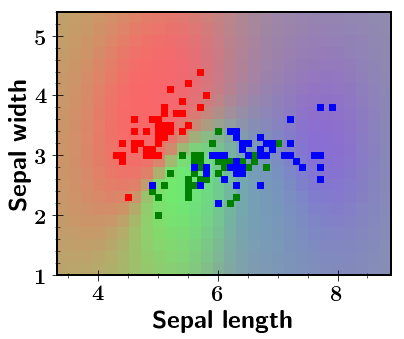

In [12]:
#Using a diferent Kernel
kernel = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(np.vstack((Sepal_length,Sepal_width)).T, class_iris)

# create a mesh to plot the predicted probabilities
x_min, x_max =Sepal_length.min() - 1, Sepal_length.max() + 1
y_min, y_max = Sepal_width.min() - 1, Sepal_width.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),np.arange(y_min, y_max, 0.2))

#Predicted probabilities
Z = gpc_rbf_anisotropic.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
#Plot
fig,ax1 = plt.subplots(figsize=(6,6), facecolor='w', edgecolor='k')
ax1.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower",alpha=0.6)

ax1.scatter(Sepal_length,Sepal_width,marker='s', c=np.array(["r", "g", "b"])[class_iris],alpha=1)
ax1.set_xlabel(r'\textbf{Sepal length}')
ax1.set_ylabel(r'\textbf{Sepal width}')